In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
ge = pd.read_csv('data/barton/Barton_combined.csv')

In [4]:
cols_wt = [c for c in ge.columns if c.startswith('WT')]
cols_mut = [c for c in ge.columns if c.startswith('Snf2')]
cols_all = cols_wt + cols_mut

In [5]:
for rounds in range(0,20):
    
    ge['mean'] = ge[cols_all].mean(axis=1)
    df = ge[ge['mean'] >= 100]
    
    for c in cols_all:
        mrat = np.median(df[c] / df['mean'])
        ge[c] = ge[c] / mrat

In [6]:
ge['WT_mean'] = ge[cols_wt].mean(axis=1)
ge['Snf2_mean'] = ge[cols_mut].mean(axis=1)

In [289]:
ge['exp_min'] = ge[cols_all].min(axis=1)

ge = ge[ge['exp_min'] > 0].copy()

ge['all_mean'] = ge[cols_all].mean(axis=1)
ge['wt_mean']  = ge[cols_wt].mean(axis=1)
ge['mut_mean'] = ge[cols_mut].mean(axis=1)

ge['all_std'] = ge[cols_all].std(axis=1,ddof=1)
ge['wt_std']  = ge[cols_wt].std(axis=1,ddof=1)
ge['mut_std'] = ge[cols_mut].std(axis=1,ddof=1)

ge['all_median'] = ge[cols_all].median(axis=1)
ge['wt_median']  = ge[cols_wt].median(axis=1)
ge['mut_median'] = ge[cols_mut].median(axis=1)

ge['true_de'] = np.log(ge['mut_median'] / ge['wt_median'])/np.log(2)
ge['abs_true_de'] = np.abs(ge['true_de'])

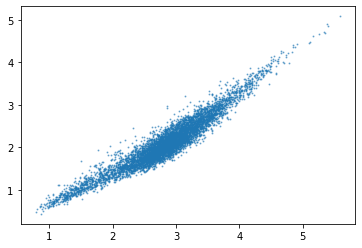

In [8]:
plt.scatter(np.log10(ge['wt_mean']),np.log10(ge['wt_std']),s=1,alpha=.5)

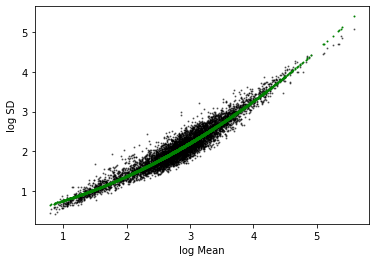

In [21]:
ge_all = ge[cols_wt]
ge_all = ge_all[ge_all.min(axis=1) > 0]

x = np.log(np.mean(ge_all,axis=1))/np.log(10)
y = np.log(np.std(ge_all,axis=1))/np.log(10)

plt.scatter(x,y,s=1,c='black',alpha=.5)
plt.xlabel('log Mean')
plt.ylabel('log SD')

pf = np.polyfit(x,y, 2, rcond=None, full=False, w=None, cov=False)

polyfun_all = np.poly1d(pf)
plt.scatter(x,polyfun_all(x),c='green',s=1)

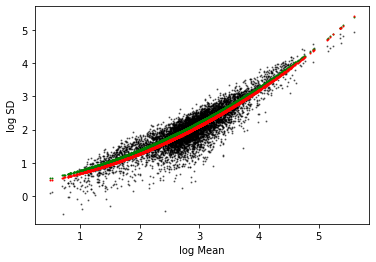

In [22]:
sample_size = 3
sam = np.random.choice(cols_wt,sample_size,replace=False)
ge_sam = ge[sam]
ge_sam = ge_sam[ge_sam.min(axis=1) > 0]

x = np.log(np.mean(ge_sam,axis=1))/np.log(10)
y = np.log(np.std(ge_sam,axis=1))/np.log(10)

plt.scatter(x,y,s=1,c='black',alpha=.5)
plt.xlabel('log Mean')
plt.ylabel('log SD')

plt.scatter(x,polyfun_all(x),c='green',s=1)

pf = np.polyfit(x,y, 2, rcond=None, full=False, w=None, cov=False)
polyfun_ss = np.poly1d(pf)
plt.scatter(x,polyfun_ss(x),c='red',s=1)


In [235]:
'c1_%02d' % 5

'c1_05'

In [280]:
x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []
x4 = []
y4 = []

pcut = .05 / np.sqrt(len(ge))

for sample_size in [3,5,10,15,20,25,30,35,40,47,48]:
    
    k1 = 'c1_%02d' % sample_size
    ge[k1] = 0
    k2 = 'c2_%02d' % sample_size
    ge[k2] = 0
    k3 = 'c3_%02d' % sample_size
    ge[k3] = 0
    k4 = 'c4_%02d' % sample_size
    ge[k4] = 0
    
    for trials in np.arange(0,100):
        
        wt_sam = np.random.choice(cols_wt,sample_size,replace=False)
        mut_sam = np.random.choice(cols_mut,sample_size,replace=False)
        
        t = scipy.stats.ttest_ind(ge[wt_sam],ge[mut_sam], axis=1, equal_var=True)
        
        ge['t1'] = t.statistic
        ge['p1'] = t.pvalue

        x1.append(sample_size)
        de = ge[ge['p1'] < pcut]
        y1.append(len(de))
        ge.loc[de.index,k1] += 1
        
        wt_mean = np.mean(ge[wt_sam],axis=1)
        mut_mean = np.mean(ge[mut_sam],axis=1)
        
        wt_std = np.std(ge[wt_sam],axis=1,ddof=1)
        mut_std = np.std(ge[mut_sam],axis=1,ddof=1)
        
        t = scipy.stats.ttest_ind_from_stats(wt_mean, wt_std, sample_size, mut_mean, mut_std, sample_size, equal_var=True)
        
        ge['t2'] = t.statistic
        ge['p2'] = t.pvalue
        
        x2.append(sample_size)
        de = ge[ge['p2'] < pcut]
        y2.append(len(de))
        ge.loc[de.index,k2] += 1
        
        wt_std = np.power(10,polyfun_all(np.log10(np.mean(ge[wt_sam],axis=1))))
        mut_std = np.power(10,polyfun_all(np.log10(np.mean(ge[mut_sam],axis=1))))
        
        t = scipy.stats.ttest_ind_from_stats(wt_mean, wt_std, sample_size, mut_mean, mut_std, sample_size, equal_var=True)
        
        ge['t3'] = t.statistic
        ge['p3'] = t.pvalue
        ge['c3'] = 0

        x3.append(sample_size)
        de = ge[ge['p3'] < pcut]
        y3.append(len(de))
        ge.loc[de.index,k3] += 1
          
        pf = np.polyfit(np.log10(wt_mean),np.log10(wt_std), 2, rcond=None, full=False, w=None, cov=False)
        polyfun_ss = np.poly1d(pf)
        
        wt_std = np.power(10,polyfun_ss(np.log10(np.mean(ge[wt_sam],axis=1))))
        mut_std = np.power(10,polyfun_ss(np.log10(np.mean(ge[mut_sam],axis=1))))
        
        t = scipy.stats.ttest_ind_from_stats(wt_mean, wt_std, sample_size, mut_mean, mut_std, sample_size, equal_var=True)
        
        ge['t4'] = t.statistic
        ge['p4'] = t.pvalue
        ge['c4'] = 0

        x4.append(sample_size)
        de = ge[ge['p4'] < pcut]
        y4.append(len(de))
        ge.loc[de.index,k4] += 1


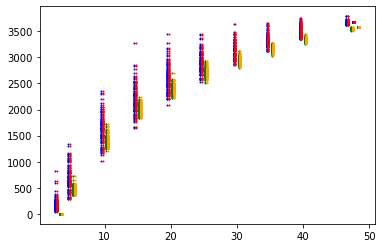

In [314]:
plt.scatter([x-.5 for x in x1],y1,c='blue',s=1)
plt.scatter([x-.25 for x in x2],y2,c='red',s=1)
plt.scatter([x+.25 for x in x3],y3,c='green',s=1)
plt.scatter([x+.5 for x in x4],y3,c='orange',s=1)

In [313]:
# define "True" positives

ge['sample_size'] = 48
ge['ttest_fs'] = scipy.stats.ttest_ind_from_stats(ge['wt_mean'], ge['wt_std'], ge['sample_size'], ge['mut_mean'], ge['mut_std'], ge['sample_size'], equal_var=False).pvalue
ge['de'] = ge['ttest_fs'] < pcut

pos_count = len(ge[ge['de'] == True])

data = []

for sample_size in np.arange(1,49):
    
    for trials in np.arange(0,10):
        
        wt_sam = np.random.choice(cols_wt,sample_size,replace=False)
        mut_sam = np.random.choice(cols_mut,sample_size,replace=False)
        
        wt_mean = np.mean(ge[wt_sam],axis=1)
        mut_mean = np.mean(ge[mut_sam],axis=1)
        
        wt_std = np.std(ge[wt_sam],axis=1,ddof=1)
        mut_std = np.std(ge[mut_sam],axis=1,ddof=1)
        
        t = scipy.stats.ttest_ind_from_stats(wt_mean, wt_std, sample_size, mut_mean, mut_std, sample_size, equal_var=False)
        
        ge['ttest_fs_sam'] = t.pvalue
        ge['de_sam'] = ge['ttest_fs_sam'] < pcut
        
        tp = len(ge[(ge['de'] == True) & (ge['de_sam'] == True)])
        tn = len(ge[(ge['de'] == False) & (ge['de_sam'] == False)])
        fp = len(ge[(ge['de'] == False) & (ge['de_sam'] == True)])
        fn = len(ge[(ge['de'] == True) & (ge['de_sam'] == False)])
        
        data.append([sample_size,trials,tp,tn,fp,fn])
        
de = pd.DataFrame(data=data,columns=['ss','trial','TP','TN','FP','FN'])


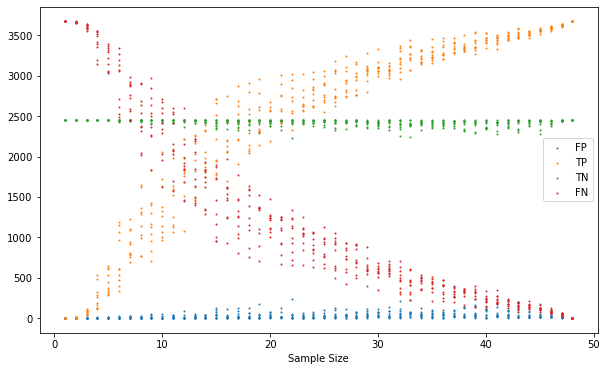

In [317]:
plt.figure(figsize=(10,6))
plt.scatter(de.ss,de.FP,label='FP',s=1)
plt.scatter(de.ss,de.TP,label='TP',s=1)
plt.scatter(de.ss,de.TN,label='TN',s=1)
plt.scatter(de.ss,de.FN,label='FN',s=1)
plt.xlabel('Sample Size')
plt.legend()

In [308]:
# define "True" positives

ge['sample_size'] = 48
ge['ttest_fs'] = scipy.stats.ttest_ind_from_stats(ge['wt_mean'], ge['wt_std'], ge['sample_size'], ge['mut_mean'], ge['mut_std'], ge['sample_size'], equal_var=False).pvalue
ge['de'] = ge['ttest_fs'] < pcut

data = []

for sample_size in np.arange(1,49):
    
    for trials in np.arange(0,10):
        
        wt_sam = np.random.choice(cols_wt,sample_size,replace=False)
        mut_sam = np.random.choice(cols_mut,sample_size,replace=False)
        
        wt_mean = np.mean(ge[wt_sam],axis=1)
        mut_mean = np.mean(ge[mut_sam],axis=1)
        
        wt_std = np.power(10,polyfun_ss(np.log10(np.mean(ge[wt_sam],axis=1))))
        mut_std = np.power(10,polyfun_ss(np.log10(np.mean(ge[mut_sam],axis=1))))
        
        t = scipy.stats.ttest_ind_from_stats(wt_mean, wt_std, sample_size, mut_mean, mut_std, sample_size, equal_var=False)
        
        ge['ttest_fs_sam'] = t.pvalue
        ge['de_sam'] = ge['ttest_fs_sam'] < pcut
        
        tp = len(ge[(ge['de'] == True) & (ge['de_sam'] == True)])
        tn = len(ge[(ge['de'] == False) & (ge['de_sam'] == False)])
        fp = len(ge[(ge['de'] == False) & (ge['de_sam'] == True)])
        fn = len(ge[(ge['de'] == True) & (ge['de_sam'] == False)])
        
        data.append([sample_size,trials,tp,tn,fp,fn])
        
de2 = pd.DataFrame(data=data,columns=['ss','trial','TP','TN','FP','FN'])


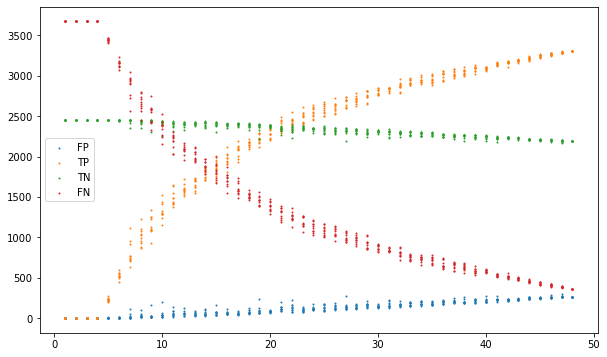

In [319]:
plt.figure(figsize=(10,6))
plt.scatter(de2.ss,de2.FP,label='FP',s=1)
plt.scatter(de2.ss,de2.TP,label='TP',s=1)
plt.scatter(de2.ss,de2.TN,label='TN',s=1)
plt.scatter(de2.ss,de2.FN,label='FN',s=1)
plt.legend()

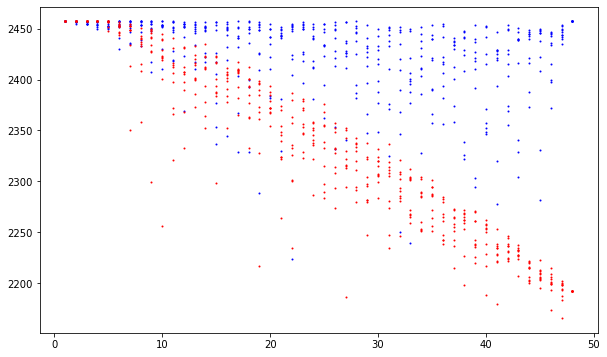

In [321]:
plt.figure(figsize=(10,6))
plt.scatter(de.ss,de.TN,c='blue',s=1)
plt.scatter(de2.ss,de2.TN,c='red',s=1)